# Load Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import datetime as dt 

from sklearn.linear_model import LinearRegression,Ridge, Lasso, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import lightgbm as lgb

import optuna

In [2]:
# Experiment parameters 
TEMPORAL_FEATURES = True
LINEAR_FEATURES = True

INTERPOLATION= True
MISSING_INTERPOLATE = 'linear' #"linear" cubicspline

HOLIDAYS = True     
NEXT_HOLIDAY = True  

VAL_SPLIT = "2018-04-01" #"2017-12-31" 

#lightgm only
OPTUNA= False 
NUM_TRIALS = 300 
BOOSTING = "gbdt" #dart

In [3]:
EPOCHS = 10000    
EARLY_STOPPING = 30
BOOSTING = "gbdt" #dart

SCALER_NAME = "MinMax"  #None MinMax Standard RobustScaler
SCALER = MinMaxScaler()  #MinMaxScaler StandardScaler RobustScaler

In [4]:
sns.set_theme(style ="whitegrid")

# Load & Set Data

In [5]:
train = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/training_Traffic.csv")
sales = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/training_Sales.csv")

gdp = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/US_GDP.csv")
gdp.set_index('Year', inplace=True)

if HOLIDAYS:
    US_holidays = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/us-federal-holidays-2011-2020.csv") 
    US_holidays["Holiday"]= 1
    US_holidays["Date"] = pd.to_datetime(US_holidays["Date"])
    US_holidays.index = pd.to_datetime(US_holidays["Date"])

In [6]:
train["Date"] = pd.to_datetime(train["Date"])
sales["Date"] = pd.to_datetime(sales["Date"])
train["Date"].max()

Timestamp('2018-05-06 21:00:00')

### Create future and historical Test Data
1. Duplicate data of the last month of Traffic - then add 1 month to this 
2. Use the Sales data to create historical test data 

In [7]:
lag_month = train["Date"].max() - pd.DateOffset(months=1)
test_time = train[train["Date"] >lag_month]["Date"] + pd.DateOffset(months=1)
test = pd.DataFrame(test_time, columns=["Date"])
test

,Date
57030,2018-05-06 22:00:00
57031,2018-05-07 00:45:00
57032,2018-05-07 09:00:00
57033,2018-05-07 09:45:00
57034,2018-05-07 10:00:00
...,...
58432,2018-06-06 18:15:00
58433,2018-06-06 18:30:00
58434,2018-06-06 18:45:00
58435,2018-06-06 19:00:00


In [8]:
# Historical dates where Traffic and Sales dont overlap 
test_historical = sales[sales["Date"] <min(train["Date"])]
test_historical.drop(["Value"], axis =1,inplace=True)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
# Set as Datetime and index
train.index = train["Date"]
train.drop(["Date"],axis=1, inplace=True)

test.index = test["Date"]
test_historical.index = test_historical["Date"]

test = test.drop(["Date"], axis =1)
test_historical = test_historical.drop("Date", axis =1)

# Missing Values 
As per the Exercise Description we have missing values \
We have the basic mean, median and mode imputations however this wont work well for timeseries values. We should therefore use processes that can infer time series values such as: 
* Spline interpolation
* Linear interpolation 
* Supervised learning 

We will use experiment with Linear and Spline interpolation as using supervised learning will take too long for this exercise 
Spline vs Linear will be set using our experiment parameters 

**Note:** 
My initial assumption was that the 0 values are missing values. However this was later revised to be missing intervals. \
These intervals were resolved during the resampling process as they were set to 0 \
Have requested confirmation from REPL

In [10]:
# if INTERPOLATION: 
#     # Set all 0 values for ease of interpolation 
#     train["Value"].replace(0,np.NaN,inplace=True)
#     print("Null values PRIOR to interpolation:", train["Value"].isna().sum() )

#     #interpolate 
#     train.interpolate(method=MISSING_INTERPOLATE,inplace=True)
#     print("Null values AFTER interpolation:", train["Value"].isna().sum() )
    
#     #As expected - 1 null value remains - this is the first value and as such cant be interpolated using our methods \
#     # We backfill it
#     train.interpolate(method='backfill', inplace=True)
#     print("Null values AFTER backfill interpolation:", train["Value"].isna().sum() )

# Resampling 

Our values are in 15 minute intervals, with some inervals not being present \
We will resample to 1 hour intervals.

In [11]:
train = train.resample("H").sum()
test = test.resample("H").sum()

In [12]:
#for later visualization 
test_index = test.index
test_hist_index = test_historical.index

<AxesSubplot:ylabel='Value'>

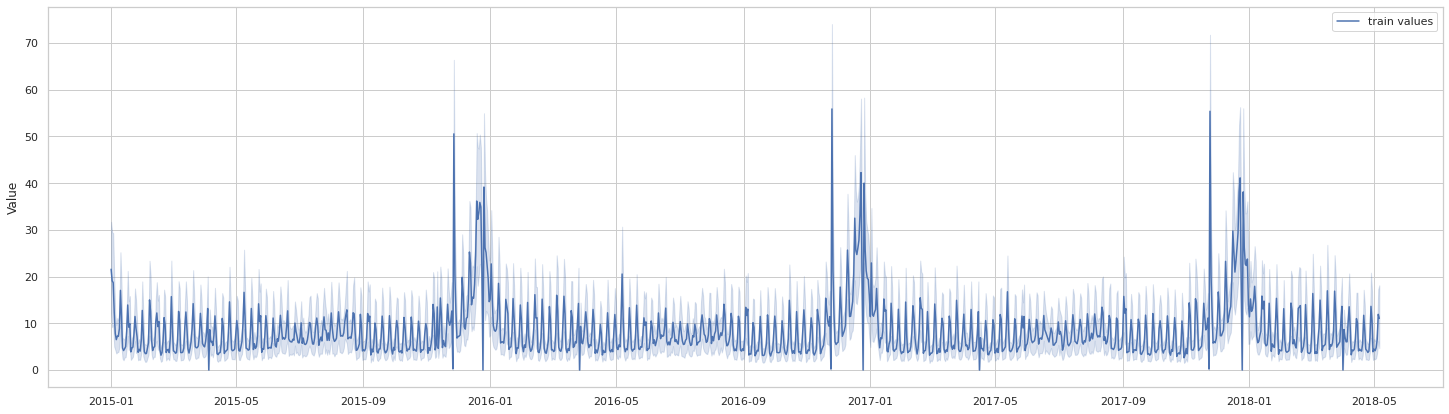

In [13]:
plt.figure(figsize=(25,7))
sns.lineplot(data = train, x = train.index.date, y = "Value", label = "train values", color = "b" )

# Feature Extraction 

In [14]:
files = [train, test, test_historical]

In [15]:
def temporal_extraction(df):
    #df["minute"] = df.index.minute
    df["hour"] = df.index.hour
    df["day"] = df.index.day
    df["month"] = df.index.month
    df["year"] = df.index.year
    
    df["is_month_start"] = df.index.is_month_start
    df["is_month_end"] = df.index.is_month_end
    
    df["Oct"] = df.index.month == 10
    df["Nov"] = df.index.month == 11
    df["Dec"] = df.index.month == 12
    df["Jan"] = df.index.month == 12
    
    df["weekofyear"] = df.index.isocalendar().week
    df["dayofweek"] = df.index.day_of_week
    
    #weekend = sat, sun 
    df["weekend_ind"] = df.index.day_of_week >=5
    df["friday"] = df.index.day_of_week ==4

    df["dayofyear"] = df.index.day_of_year
    df['inverse_dayofyear'] = 365 - df.index.dayofyear
    
    #2016 is a leap year 
    df.loc[df["year"] == 2016 , "inverse_dayofyear"] = df.loc[df["year"] == 2016 , "inverse_dayofyear"]+1
    
    #lets set quarters to a categorical feature as it I suspect this may better for boosting models to use categorical rather than numerical
    df['quarter'] = 'Q' + df.index.quarter.astype(str)
    df["daysinmonth"] = df.index.daysinmonth
    
    return df 

if TEMPORAL_FEATURES: 
    for file in files:
        temporal_extraction(file)

In [16]:
# Decompose any seasonal pattersn using sine and cosine functions (Fourier Series)
def linear_extractions(df):
    for k in range(1,20):
        df[f'sin{k}'] = np.sin(df.index.dayofyear / 365 * 2 * np.pi * k)
        df[f'cos{k}'] = np.cos(df.index.dayofyear / 365 * 2 * np.pi * k)
        
    df["sin_month"] = (np.sin(2 * np.pi * df.index.month/12))
    df['cos_month'] = (np.cos(2 * np.pi * df.index.month/12))
    df['sin_day'] = (np.sin(2 * np.pi * df.index.day/31))
    df['cos_day'] = (np.cos(2 * np.pi * df.index.day/31))
    df['sin_hour'] = (np.sin(2 * np.pi * df.index.hour/24))
    df['cos_hour'] = (np.cos(2 * np.pi * df.index.hour/24))
    df['sin_minute'] = (np.sin(2 * np.pi * df.index.minute/60))
    df['cos_minute'] = (np.cos(2 * np.pi * df.index.minute/60))
    
    return df 

if LINEAR_FEATURES:
    for file in files:
        linear_extractions(file)

In [17]:
def get_gdp(row):
    year = gdp[gdp.index ==row]["GPD_USD"].values[0]
    #print(year)
    return year

for file in files:
    file["gdp"] = file["year"].apply(lambda x : get_gdp(x) )

In [18]:
def get_holidays(x):
    #print(x)
    if dt.date(x.loc['year'], x.loc['month'], x.loc['day']) in US_holidays.index.date:
        hol = 1
    else:
        hol =0
    return hol

if HOLIDAYS:
    print("Applying Holidays")
    for file in files:
        file["holiday"] = file.apply(lambda x: get_holidays(x) , axis =1 )

Applying Holidays


In [19]:
def next_Holiday(x):
    #print(x) 
    date = dt.date(x.loc['year'], x.loc['month'], x.loc['day'])
    

    try:
        nextDate = min([day for day in US_holidays.index if day >= date]).date()
    except ValueError:
        #no next holiday
        nextDate = date
    return (nextDate - date).days

if NEXT_HOLIDAY:
    print("Applying Next Holiday")
    for file in files:
        file['daysTillHoliday'] = file.apply(lambda x: next_Holiday(x), axis=1)

Applying Next Holiday


## Onehot Encoding 

In [20]:
categorical_feats = ["quarter"]

In [21]:
# Come back to this - drop first may no be needed

train = pd.get_dummies(train,columns= categorical_feats,drop_first=True)
test = pd.get_dummies(test,columns= categorical_feats, drop_first=False)
test_historical = pd.get_dummies(test_historical,columns= categorical_feats, drop_first=True)

# As test only has 1 quarter
test["quarter_Q3"] = 0
test["quarter_Q4"] = 0

# Split & Scale

In [22]:
train.sort_index(inplace=True)

In [23]:
X = train.drop("Value", axis=1)
y= train["Value"]

In [24]:
def train_test_split(X, y):
    X_train =X[X.index<=VAL_SPLIT]
    X_test = X[X.index>VAL_SPLIT]
    
    y_train= y[y.index<=VAL_SPLIT]
    y_test = y[y.index>VAL_SPLIT]

    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = train_test_split(X,y)

### Scaling

In [25]:
def scale_data(X_train, X_test, test, test_historical= None):
    scaler= SCALER
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    test = scaler.transform(test)
    
    if test_historical is not None:
        test_historical = scaler.transform(test_historical)
    
    return X_train, X_test, test, test_historical

In [26]:
if SCALER_NAME !="None":
    print(f"Scaling with {SCALER_NAME}")
    X_train, X_test, test , test_historical= scale_data(X_train, X_test, test, test_historical)

Scaling with MinMax


In [27]:
X_train

array([[0.43478261, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.47826087, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.52173913, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.95652174, 1.        , 0.18181818, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.18181818, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.27272727, ..., 1.        , 0.        ,
        0.        ]])

# OPTUNA (Lightgbm Hyperparameter Tuning)

In [28]:
def objective_lgb(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    params = {
        "num_threads": -1,
        "verbose" : -1,
        "boosting_type":"gbdt",
        "objective":trial.suggest_categorical("objective", ['poisson', 'mape', 'rmse']),
        "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 0.10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),  #usually less than 2**max depth
        'max_bin': trial.suggest_int('max_bin', 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf":trial.suggest_int('min_data_in_leaf', 10,200)
    }
    
    metric_optuna = trial.suggest_categorical("metric", ['poisson', 'mape', 'rmse',])
    
    params["metric"] = metric_optuna
    
    train_data = lgb.Dataset(X_train, label=y_train,)
    test_data =lgb.Dataset(X_test,label=y_test )

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, metric= metric_optuna)
    
    ## CREATE lightgbm model
    model = lgb.train(params=params,
                      train_set= train_data, 
                      num_boost_round= EPOCHS,
                      valid_sets= [test_data], 
                      callbacks=[lgb.early_stopping(EARLY_STOPPING),
                                 pruning_callback
                                ]
                     )

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    print("RMSE", np.sqrt(mse))
    print("R2", r2_score(y_test, y_pred))
    
    return np.sqrt(mse)

In [29]:
if OPTUNA:
    print("RUNNINING OPTUNA LIGHTGBM")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective_lgb, n_trials=NUM_TRIALS)
    trial = study.best_trial

In [30]:
if OPTUNA:
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial num :",trial.number)
    print(" RMSE Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

# Model

In [31]:
if OPTUNA: 
    print("Using Optuna params")
    lgb_params = trial.params

else:
    lgb_params= {
        'objective': 'poisson',
        'learning_rate': 0.09489135010808002,
        'lambda_l1': 0.026487042302698768,
        'lambda_l2': 4.811566048746324e-08,
        'num_leaves': 112,
        'max_bin': 734,
        'max_depth': 6,
        'min_data_in_leaf': 49,
    }

#### LightGBM

In [32]:
def fit_model_lgb(X_train,y_train,X_test,y_test):
    
    train_data = lgb.Dataset(X_train, label=y_train,)
    test_data =lgb.Dataset(X_test,label=y_test )

    ## CREATE lightgbm model
    model = lgb.train(params=lgb_params,
                      train_set= train_data, 
                      num_boost_round= EPOCHS,
                      valid_sets= [test_data], 
                      callbacks=[lgb.early_stopping(EARLY_STOPPING)],
                     )

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    print("RMSE", np.sqrt(mse))
    print("R2", r2_score(y_test, y_pred))
    
    #Predict test 
    test_preds = model.predict(test)
    
    return y_pred,test_preds,  model
    

#### Ridge

In [33]:
def fit_model_ridge(X_train,y_train,X_test,y_test):

    ## CREATE lightgbm model
    model = Ridge()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, 1, max(y_pred))
    
    mse = mean_squared_error(y_test, y_pred)
    print("RMSE", np.sqrt(mse))
    print("R2", r2_score(y_test, y_pred))
    
    #Predict test 
    test_preds =  model.predict(test) 

    return y_pred,test_preds,  model

In [34]:
print("Running Lightgbm ")
y_pred, test_preds_lgb, model_lgb = fit_model_lgb(X_train, y_train, X_test, y_test)
print("\mRunning Ridge")
y_pred, test_preds_ridge, model_ridge = fit_model_ridge(X_train, y_train, X_test, y_test)

Running Lightgbm 
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14145
[LightGBM] [Info] Number of data points in the train set: 28455, number of used features: 67
[LightGBM] [Info] Start training from score 2.133048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

## Predict historical
We will use Ridge model for historical predictions

In [35]:
test_preds_hist = model_ridge.predict(test_historical.round())

In [36]:
test_preds_hist

array([21.61927711, 21.61927711, 21.61927711, ..., 28.50881353,
       28.50881353, 28.50881353])

# Post Processing 
* Rounding 
* Clipping 

In [37]:
# We will set the future predictions to LightGBM predictions 
#As the actual values are integers we will round the floats
test_preds = test_preds_lgb.round()
test_preds[: 10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

**Note:** 
Our model may predicted negative values dependent on model and scaling \
We will clip these to 0 as we will never have negative Traffic 

In [38]:
test_preds_hist = np.clip(test_preds_hist, 0, max(test_preds_hist))
test_preds = np.clip(test_preds, 0, max(test_preds))
test_preds[: 10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Submission and visualization 

In [39]:
#Save Data 
test_future = pd.DataFrame(data= test_preds,columns=["Value"], index=test_index)
test_hist = pd.DataFrame(data= test_preds_hist,columns=["Value"], index=test_hist_index)

# concat train actual and historical preds 
pd.concat([train, test_hist],axis =0).to_csv("training_Traffic_Full.csv")

#Save Submission 
test_future.to_csv("Predicted_Traffic_Values.csv")   

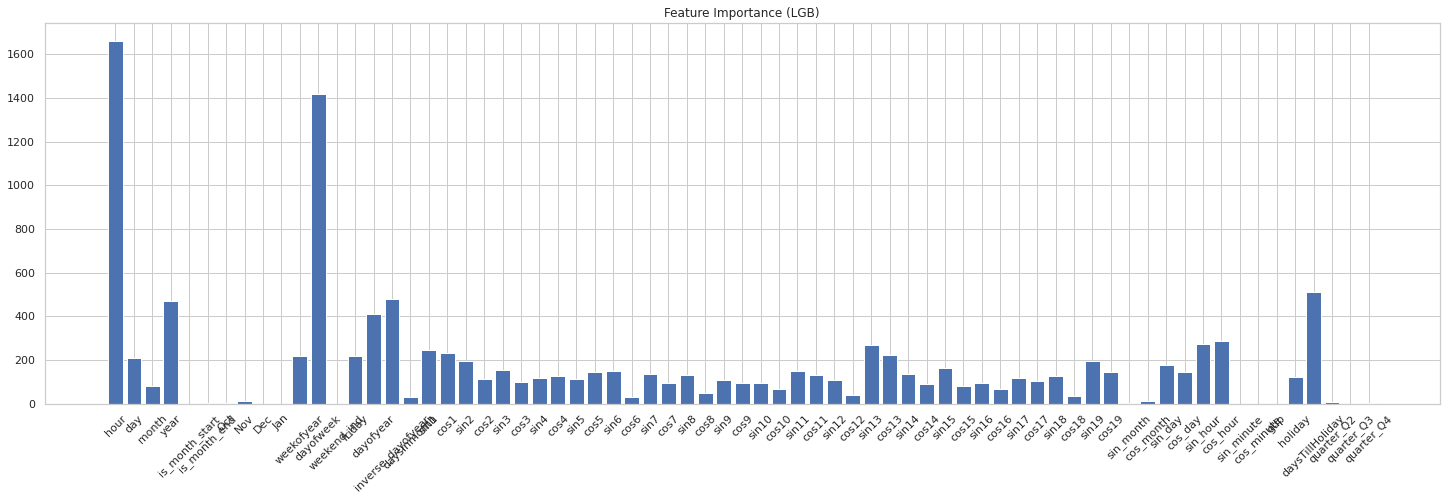

In [40]:
plt.figure(figsize=(25,7))
plt.bar(x = X.columns ,height=model_lgb.feature_importance())
plt.xticks(rotation=45)
plt.title("Feature Importance (LGB)")

plt.show()

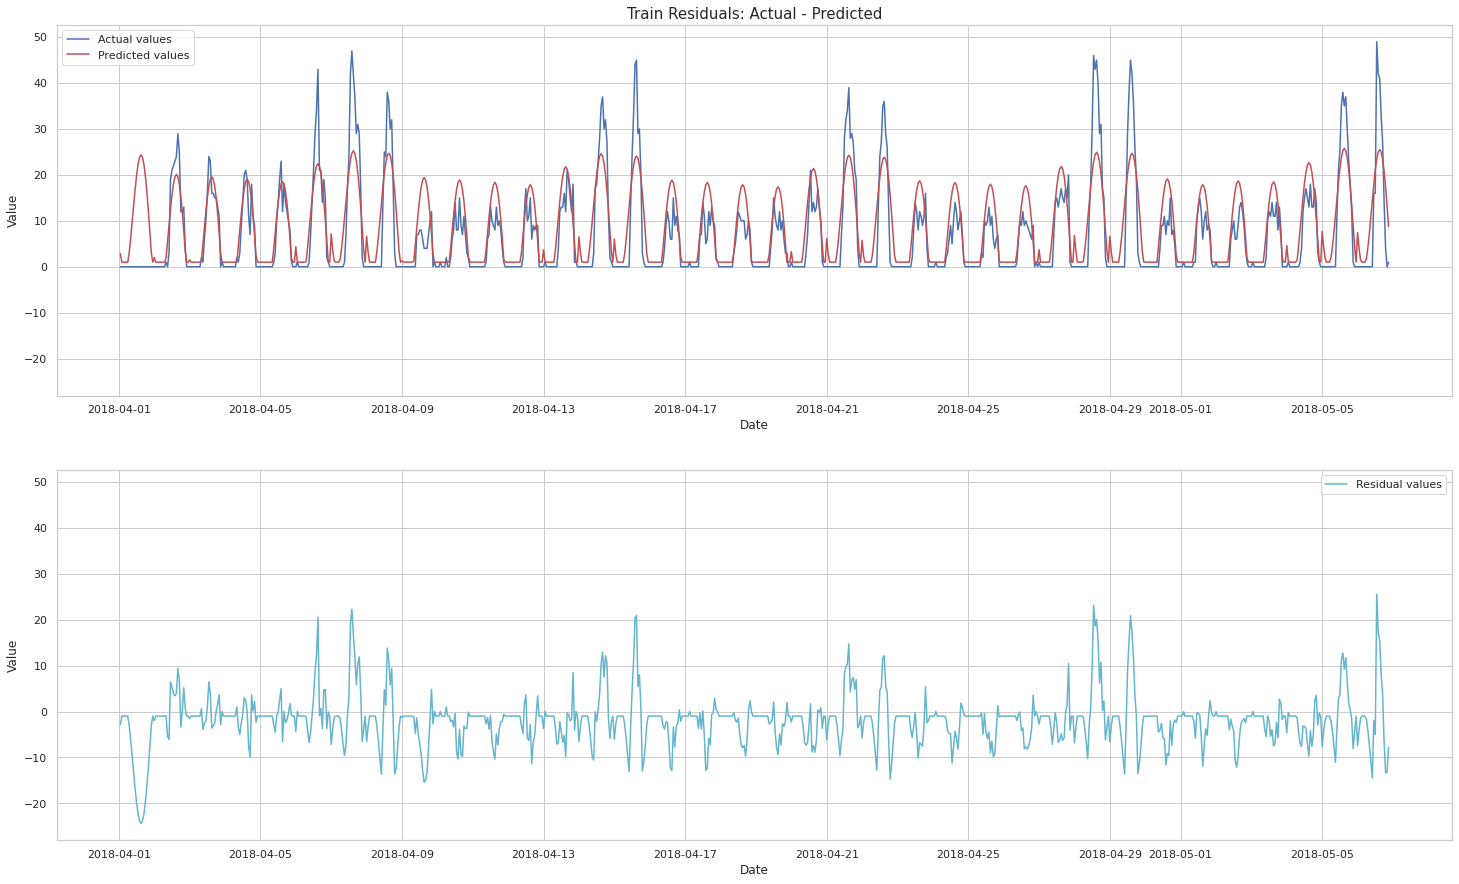

In [41]:
fig,ax = plt.subplots(2,1, figsize=(25,15),sharey= True)

sns.lineplot(ax= ax[0], x = y_test.index, y =y_test, label = "Actual values", color = "b" )
sns.lineplot(ax= ax[0], x = y_test.index, y =y_pred, label = "Predicted values", color = "r" )
ax[0].set_title('Train Data: Actual vs Predicted',fontdict={'fontsize': 15}) 

diff_sales = y_test - y_pred
sns.lineplot(ax= ax[1], x = y_test.index, y =diff_sales, label = "Residual values", color = "c" )
ax[0].set_title('Train Residuals: Actual - Predicted',fontdict={'fontsize': 15}) 

plt.show()

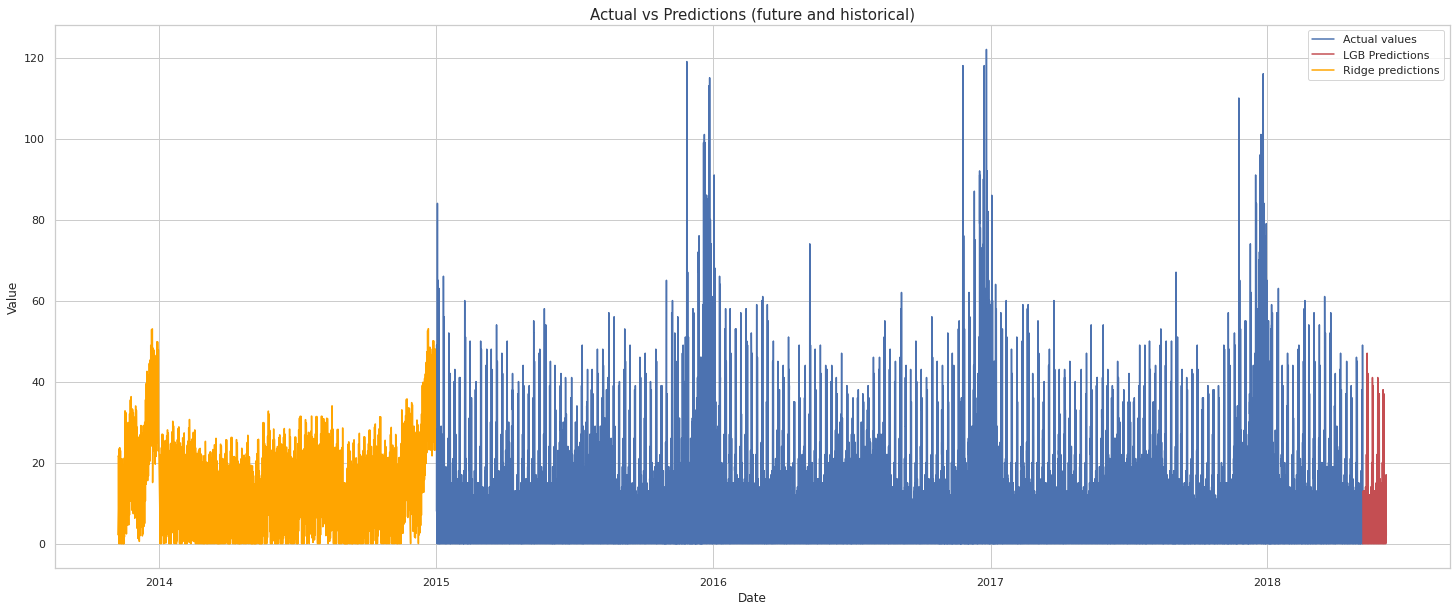

In [42]:
plt.figure(figsize=(25,10))

sns.lineplot(data = train["Value"] , label = "Actual values", color = "b" )
sns.lineplot(x = test_index, y =test_preds, label = "LGB Predictions", color = "r" )
sns.lineplot(x = test_hist_index, y =test_preds_hist, label = "Ridge predictions", color = "orange" )

plt.title('Actual vs Predictions (future and historical)',fontdict={'fontsize': 15}) 
plt.show()

# Results / Models

## 1. Lightgbm 
#### Baseline - Temporal Features - no holidays - no scaling
* RMSE 1.6803342510839538  
* R2 0.6435006788345745 

#### Scaling (only temporal features)
* MinMAX Scaler-----------------------RMSE 1.6818988764409812 | R2 0.6428364686437487
* RobustScaler------------------------RMSE 1.6781353122314502 | R2 0.6444331210272347   
* **Standard Scaler**-----------------RMSE 1.6748951745295155 | R2 0.6458048500174878    
* No Scaling--------------------------RMSE 1.6803342510839538 | R2 0.6435006788345745        

#### Features (Standard Scaler) 
* Temporal + Linear-------------------------------------RMSE 1.6494708801935656 | R2 0.6564763408134371
* Added features Minute and week -----------------------RMSE 1.6179395512542862 | R2 0.669484424246463
* **Added features month_start/end**--------------------RMSE 1.6164286894844746 | R2 0.6701014191026651
* Add all sin and cosine -------------------------------RMSE 1.625365543031272  | R2 0.6664434718927101

#### OPTUNA PARAMS - 
*  STD Scaler - Resampled -  RMSE 3.561757343912725 | R2 0.8736259716642867

## 2. Ridge
#### Std Scaler
* no log-----------RMSE  2.033493105680091 | R2 0.4779011266696763
* with log-----------RMSE 1.9374081475221534 | R2 0.5260750303621129
* with log1p-----------RMSE 1.9232039132626655  | R2 0.5329987797005891

#### Minmax
* no log-----------RMSE 2.032405927249337 | R2 0.478459243044537  
* with log-----------RMSE 1.9428393790942178  | R2 0.5234141515314411
* with log1p-----------RMSE 1.9267755429308595  | R2 0.531262609965631

**Note** the resulting graph of log transformation, although has a better score has less variation in the results
As such will exclude this tranformation 

#### Clip values (0, max(x))  
Resampled - no log -Min Max - RMSE 5.947771078344503 | R2 0.6475985699919571

# Final Note
Will Use LightGBM for future Traffic and Ridge for historical Traffic predictions 